# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 7: Análisis de redes sociales

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 22 de septiembre de 2024


Enlace al repositorio: https://github.com/LINDAINES213/Lab7_DataScience.git


Para lograr ejecutar correctamente el notebook, se proporciona un requirements que tiene todas las librerias necesarias. Es importante realizar la observación que debido a las distintas versiones, se utilizó pythom 3.8 para lograr que todos los requerimientos se instalen correctamente. 

In [173]:
import os
import json
import re
import nltk
import pydot
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from IPython.display import Image, display
from networkx.drawing.nx_pydot import write_dot, read_dot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community.community_louvain as community_louvain
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

### 💻 Carga de la información

In [174]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

df_tweets = pd.DataFrame(tweets)
print(df_tweets)

                       id               id_str  \
0     1834281080029110288  1834281080029110288   
1     1834252464092069901  1834252464092069901   
2     1834280919336976681  1834280919336976681   
3     1834280512933732694  1834280512933732694   
4     1834279986254987428  1834279986254987428   
...                   ...                  ...   
5014  1832570119563743682  1832570119563743682   
5015  1832569640079270018  1832569640079270018   
5016  1832569563109896313  1832569563109896313   
5017  1832568528508968963  1832568528508968963   
5018  1832567980749660272  1832567980749660272   

                                                    url  \
0     https://x.com/La_ReVoluZzion/status/1834281080...   
1     https://x.com/XelaNewsGt/status/18342524640920...   
2     https://x.com/M24095273/status/183428091933697...   
3     https://x.com/carlosalbesc/status/183428051293...   
4     https://x.com/Brenda_AGN/status/18342799862549...   
...                                          

### 🧹 Limpieza y preprocesamiento de datos

Como parte inicial se decide eliminar columnas duplicadas de IDs. Además, se remueven columnas que cuentan en su mayoría con valores nulos ya que no aportan información de manera significativa respecto al total de datos. 

In [175]:
df_tweets.head(10)
df_tweets.columns

Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')

In [176]:
for i in ['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr']:
    if i in df_tweets.columns:
        df_tweets = df_tweets.drop(columns=['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr'])

In [177]:
df_tweets.head(10)
df_tweets[['_type']].nunique()

_type    1
dtype: int64

In [178]:
for i in ['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr', '_type']:
    if i in df_tweets.columns:
        df_tweets = df_tweets.drop(columns=['_type'])

In [179]:
df_tweets.head(10)
df_tweets[['card']]
df_tweets[['card']].count()

non_null_values = df_tweets['card'].dropna()
print(non_null_values)

11      {'title': '🔴 | El presidente @BArevalodeLeon p...
22      {'title': '🔴 | El presidente @BArevalodeLeon p...
33      {'title': '🔴 | El presidente @BArevalodeLeon p...
34      {'title': '🔴 | El presidente @BArevalodeLeon p...
136     {'title': 'Xela News (@xelanewsgt) • Instagram...
439     {'title': 'Fabiola Roudha interpreta el himno ...
483     {'title': 'Resumen de noticias – miércoles 11 ...
624     {'title': 'CC anula fallo que confirmó condena...
685     {'title': 'Ricardo Mendez Ruiz', 'description'...
749     {'title': 'MP busca retirar la inmunidad del p...
801     {'title': 'Arévalo comparte con pobladores de ...
882     {'title': 'MP busca retirar la inmunidad del p...
985     {'title': 'TikTok · Fernando Cajas', 'descript...
1012    {'title': 'Presidente resalta el valor de los ...
1134    {'title': 'Más de 9 mil familias con insegurid...
1245    {'title': 'El futuro del agua', 'description':...
1430    {'title': 'Presidente Arévalo resalta legado e...
1432    {'titl

In [180]:
if 'card' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['card'])

In [181]:
df_tweets[['coordinates']].count()
if 'coordinates' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['coordinates'])

In [182]:
df_tweets.head(10)
df_tweets[['lang']].count()
df_tweets[['lang']].nunique()

lang    20
dtype: int64

In [183]:
df_tweets[['place']].count()

on_null_values = df_tweets['place'].dropna()
print(non_null_values)

df_tweets[['place']].count()
if 'place' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['place'])

11      {'title': '🔴 | El presidente @BArevalodeLeon p...
22      {'title': '🔴 | El presidente @BArevalodeLeon p...
33      {'title': '🔴 | El presidente @BArevalodeLeon p...
34      {'title': '🔴 | El presidente @BArevalodeLeon p...
136     {'title': 'Xela News (@xelanewsgt) • Instagram...
439     {'title': 'Fabiola Roudha interpreta el himno ...
483     {'title': 'Resumen de noticias – miércoles 11 ...
624     {'title': 'CC anula fallo que confirmó condena...
685     {'title': 'Ricardo Mendez Ruiz', 'description'...
749     {'title': 'MP busca retirar la inmunidad del p...
801     {'title': 'Arévalo comparte con pobladores de ...
882     {'title': 'MP busca retirar la inmunidad del p...
985     {'title': 'TikTok · Fernando Cajas', 'descript...
1012    {'title': 'Presidente resalta el valor de los ...
1134    {'title': 'Más de 9 mil familias con insegurid...
1245    {'title': 'El futuro del agua', 'description':...
1430    {'title': 'Presidente Arévalo resalta legado e...
1432    {'titl

In [184]:
df_tweets.head(10)
if 'source' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['source'])

In [185]:
non_empty_count = df_tweets['cashtags'].apply(lambda x: len(x) > 0).sum()
print(f'Número de listas con al menos un valor: {non_empty_count}')

Número de listas con al menos un valor: 2


In [186]:
if 'cashtags' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['cashtags'])

In [187]:
print(f'Numero de retweets: {df_tweets["retweetedTweet"].sum()}')

Numero de retweets: 0


In [188]:
df_tweets[['retweetedTweet']].count()
if 'retweetedTweet' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['retweetedTweet'])

In [189]:
non_empty_count = df_tweets['links'].apply(lambda x: len(x) > 0).sum()
print(f'Número de listas con al menos un valor: {non_empty_count}')
if 'links' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['links'])

Número de listas con al menos un valor: 120


Luego, centrandonos en la información del propio texto del tweet, se deciden realizar ciertas operaciones de limpieza que ayuden en el análisis de la información que este contiene. Las operaciones de limpieza que se realizaron sobre rawContent son:
- Convertir el texto a minúsculas (para asegurar la normalización de los hashtags y las menciones)
- Remover URLs
- Eliminar carácteres especiales.
- Reemplazar saltos de línea por espacios.
- Eliminar stopwords. 
- Eliminar menciones.
- Eliminar hashtags. 

In [190]:
df_tweets_cleaned = df_tweets.copy()
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].str.lower()
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'[^a-zA-Z0-9áéíóúñ@#\s]', '', x))
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' '))

nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))
def remove_stopwords(text):
    words = text.split()  
    filtered_words = [word for word in words if word not in spanish_stopwords] 
    return ' '.join(filtered_words)

df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(remove_stopwords)
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'@\w+', '', x.replace('\n', ' ').replace('\r', ' ')))
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'[@#]\w+', '', x.replace('\n', ' ').replace('\r', ' ')))

print(df_tweets_cleaned[['rawContent']].head())

                                          rawContent
0  confirmado compañeres impuesto  solo cuenta pa...
1   medios  informaron ayer acerca visita preside...
2    usaste pegasus espiar detractores obra narci...
3         entienden bien cuadrando productivareunión
4  presidente  vicepresidenta  participan sesión ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Como las menciones fueron convertidas a minúsculas los usernames correspondientes también fueron convertidos a su versión minúscula para seguir la misma estructura. Para esto se utilizaron las funciones auxiliares proporcionadas abajo. 

In [191]:
def process_user(user, property_name):
    if isinstance(user, dict) and property_name in user:
        user[property_name] = user[property_name].lower()
    return user

In [192]:
def process_user2(user, property_name):
    if user:
        if property_name in user['user']:
            user['user'][property_name] = user['user'][property_name].lower()
    return user

In [193]:
def process_user3(user, property_name):
    if user:
        for i in user:
            if isinstance(i, dict) and property_name in i:
                i[property_name] = i[property_name].lower()
    return user

In [194]:
df_tweets_cleaned['user'] = df_tweets_cleaned['user'].apply(lambda x: process_user(x, 'username'))
df_tweets_cleaned['inReplyToUser'] = df_tweets_cleaned['inReplyToUser'].apply(lambda x: process_user(x, 'username'))
df_tweets_cleaned['quotedTweet'] = df_tweets_cleaned['quotedTweet'].apply(lambda x: process_user2(x, 'username'))
df_tweets_cleaned['mentionedUsers'] = df_tweets_cleaned['mentionedUsers'].apply(lambda x: process_user3(x, 'username'))

In [195]:
def convert_hashtags_to_lowercase(hashtags):
    return [hashtag.lower() for hashtag in hashtags]

In [196]:
df_tweets_cleaned['hashtags'] = df_tweets_cleaned['hashtags'].apply(convert_hashtags_to_lowercase)

Además, en función del contenido existente en rawContent, se eliminan tweets que estén duplicados en el dataset. 

In [197]:
duplicated_count = df_tweets['rawContent'].duplicated().sum()
print(f'Número de tweets duplicados: {duplicated_count}')
df_tweets_cleaned = df_tweets_cleaned.drop_duplicates(subset=['rawContent'])

Número de tweets duplicados: 86


In [198]:
duplicated_count = df_tweets_cleaned['rawContent'].duplicated().sum()
print(f'Número de tweets duplicados: {duplicated_count}')

Número de tweets duplicados: 0


### 📚 Análisis exploratorio

Observando cómo se encuentra formada la información del usuario, menciones, retweets, respuestas entre otros. 

In [199]:
dfUser = df_tweets_cleaned[1:2]['user']
for i in dfUser:
    print(i)

{'id': 956650778634145792, 'id_str': '956650778634145792', 'url': 'https://x.com/XelaNewsGt', 'username': 'xelanewsgt', 'displayname': 'XelaNews', 'rawDescription': 'Noticias sin injerencias.', 'created': '2018-01-25 22:11:34+00:00', 'followersCount': 3462, 'friendsCount': 359, 'statusesCount': 2915, 'favouritesCount': 5717, 'listedCount': 3, 'mediaCount': 1132, 'location': 'Guatemala', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1795602273034199040/B_YZsc0K_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/956650778634145792/1704817554', 'protected': None, 'verified': False, 'blue': False, 'blueType': None, 'descriptionLinks': [], 'pinnedIds': [], '_type': 'snscrape.modules.twitter.User'}


In [200]:
dfInReplyToUser = df_tweets_cleaned[3:4]['inReplyToUser']
for i in dfInReplyToUser:
    print(i)

{'id': 77653794, 'id_str': '77653794', 'username': 'ivanduque', 'displayname': 'Iván Duque 🇨🇴', '_type': 'snscrape.modules.twitter.UserRef'}


In [201]:
dfMentionedUsers = df_tweets_cleaned[0:1]['mentionedUsers']
for i in dfMentionedUsers:
    for j in i:
        print(j)

{'id': 23664866, 'id_str': '23664866', 'username': 'usembassyguate', 'displayname': 'US Embassy Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 1001171061831020545, 'id_str': '1001171061831020545', 'username': '48cantonestoto', 'displayname': '48 Cantones Oficial', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 262691982, 'id_str': '262691982', 'username': 'usaidguate', 'displayname': 'USAID Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 1362391326, 'id_str': '1362391326', 'username': 'ueguatemala', 'displayname': 'Unión Europea en Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 945378369818058752, 'id_str': '945378369818058752', 'username': 'barevalodeleon', 'displayname': 'Bernardo Arévalo', '_type': 'snscrape.modules.twitter.UserRef'}


In [202]:
dfQuotedTweet = df_tweets_cleaned[0:1]['quotedTweet']
for i in dfQuotedTweet:
    print(i)
    

{'id': 1834252464092069901, 'id_str': '1834252464092069901', 'url': 'https://x.com/XelaNewsGt/status/1834252464092069901', 'date': '2024-09-12 15:27:20+00:00', 'user': {'id': 956650778634145792, 'id_str': '956650778634145792', 'url': 'https://x.com/XelaNewsGt', 'username': 'xelanewsgt', 'displayname': 'XelaNews', 'rawDescription': 'Noticias sin injerencias.', 'created': '2018-01-25 22:11:34+00:00', 'followersCount': 3462, 'friendsCount': 359, 'statusesCount': 2915, 'favouritesCount': 5717, 'listedCount': 3, 'mediaCount': 1132, 'location': 'Guatemala', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1795602273034199040/B_YZsc0K_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/956650778634145792/1704817554', 'protected': None, 'verified': False, 'blue': False, 'blueType': None, 'descriptionLinks': [], 'pinnedIds': [], '_type': 'snscrape.modules.twitter.User'}, 'lang': 'es', 'rawContent': '#URGENTE Lo que los medios #faferos no informaron ayer, acerca de la

Después de la limpieza y filtrado de usuarios se observa que se cuenta con 4713 entradas en total. La información relevante se encuentra en las columnas que contienen elementos de tipo objeto en su mayoría, ya que con estos se lograrán establecer relaciones y formar los grafos. 

In [203]:
df_tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4545 entries, 0 to 5018
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4545 non-null   int64  
 1   date              4545 non-null   object 
 2   user              4545 non-null   object 
 3   lang              4545 non-null   object 
 4   rawContent        4545 non-null   object 
 5   replyCount        4545 non-null   int64  
 6   retweetCount      4545 non-null   int64  
 7   likeCount         4545 non-null   int64  
 8   quoteCount        4545 non-null   int64  
 9   bookmarkedCount   4545 non-null   int64  
 10  conversationId    4545 non-null   int64  
 11  hashtags          4545 non-null   object 
 12  mentionedUsers    4545 non-null   object 
 13  viewCount         4470 non-null   float64
 14  quotedTweet       258 non-null    object 
 15  inReplyToTweetId  3918 non-null   float64
 16  inReplyToUser     3998 non-null   object 
 17  

In [204]:
df_tweets_cleaned.describe()

id   replyCount  retweetCount     likeCount   quoteCount  \
count  4.545000e+03  4545.000000   4545.000000   4545.000000  4545.000000   
mean   1.832827e+18     6.602200     18.636304     94.880748     1.553135   
std    2.265285e+16   113.507436    257.707512   1818.577724    26.237587   
min    8.094212e+17     0.000000      0.000000      0.000000     0.000000   
25%    1.833205e+18     0.000000      0.000000      0.000000     0.000000   
50%    1.833600e+18     0.000000      0.000000      0.000000     0.000000   
75%    1.833908e+18     0.000000      0.000000      2.000000     0.000000   
max    1.834281e+18  4783.000000   8307.000000  67416.000000  1336.000000   

       bookmarkedCount  conversationId     viewCount  inReplyToTweetId  
count      4545.000000    4.545000e+03  4.470000e+03      3.918000e+03  
mean          4.215402    1.832302e+18  6.118750e+03      1.832967e+18  
std         107.150238    2.446949e+16  1.554745e+05      1.002718e+16  
min           0.000000    8.094212e+17  1.000000e+00      1.257873e+18  
25%           0.000000    1.832935e+18  8.000000e+00      1.832977e+18  
50%           0.000000    1.833493e+18  2.400000e+01      1.833493e+18  
75%           0.000000    1.833663e+18  8.300000e+01      1.833660e+18  
max        5277.000000    1.834281e+18  8.495723e+06      1.834279e+18

Resulta interesante notar que del total de tweets, prácticamente la mitad son usuarios únicos por lo que se podría indicar que en promedio hay 2 tweets de cada usuario.

In [205]:
df_tweets_cleaned['user']
usersList = []
for i in df_tweets_cleaned['user']:
    usersList.append(i['username'])

print(f'Número de usuarios únicos: {len(set(usersList))}')

Número de usuarios únicos: 2477


La información obtenida del conteo de palabras más frecuentes obviando la de Guatemala, indica que el conjunto se centra en las decisiones del gobierno. En este caso la mayor frecuencia se centra en temas urgentes, el Ministerio Finanzas, el Diario de Centro América y principalemente en el presupuesto para el 2025.

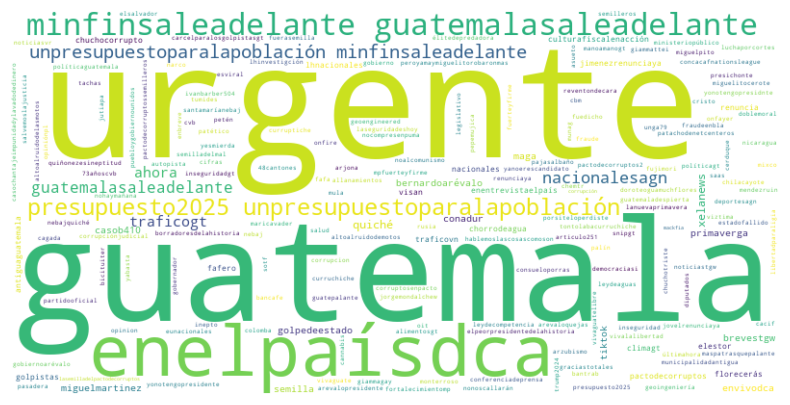

In [206]:
dfHashtags = df_tweets_cleaned[df_tweets_cleaned['hashtags'].apply(lambda x: len(x) > 0)]
hashtags = [hashtag for sublist in dfHashtags['hashtags'] for hashtag in sublist]
text = ' '.join(hashtags)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Observando la frecuencia de palabras en los tweets (tomando en cuenta todo el conjunto de palabras) se observa que todas hablan del propio presidente Bernardo Arévalo, así como todo lo relacionado al Gobierno de Guatemala.

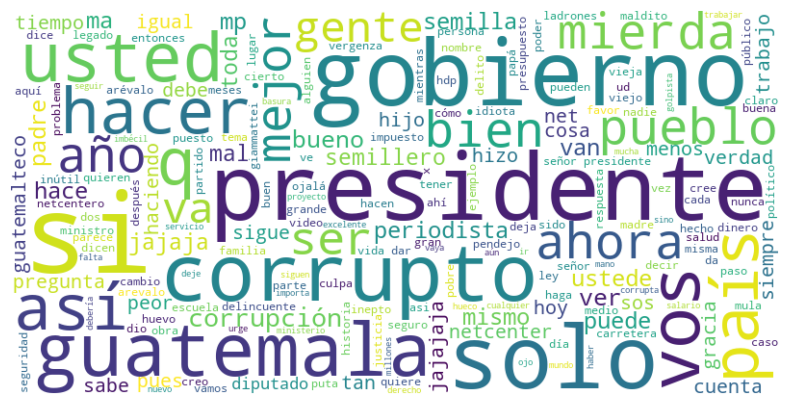

In [207]:
textTweets = ' '.join(df_tweets_cleaned['rawContent'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textTweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

De esta información, se plantean 3 temas principales a identificar. 

- ¿Cómo es la aceptación del presidente? 
Únicamente utilizando la información obtenida por el análisis exploratorio se podría decir que la aceptación del presidente no es principalmente positiva ya que dentro de las palabras más mencionadas o consideradas más frecuentes dentro de la nube de palabras se encuentra corrupto. En el apartado de palabras menos frecuentes, existen más diversidad, lo cual es un indicador de opiniones divididas.
- ¿Qué opinión (en términos positivos y/o negativos) tienen los guatemaltecos sobre el presupuesto 2025? 
Se puede indicar que para los guatemaltecos es un tema urgente y de vital importancia ya que tienen en la mira al ministerio de finanzas públicas y a los encargados de llevar a cabo este proceso.
- ¿Existen estructuras de usuarios encargadas de mejorar o manipular la imagen del presidente?
Únicamente con el contexto del análisis exploratorio y de la información con la que se cuenta, es díficl indicar que existen estructuras de este tipo. Sin embargo, se pueden notar tendencias que indican descontento de ciertos grupos al utilizar el hashtag "yonotengopresidente" y a su vez, otro segmento o grupo identificable es el de "pactodecorruptos". Destacable es el uso de palabras como "netcentero/netcenter" o "semillero" por algunos usuarios para referirse a ciertas estructuras.  

### 👥 Análisis de la topología de la red.

Se realiza un grafo en base a las menciones realizadas en los tweets. 

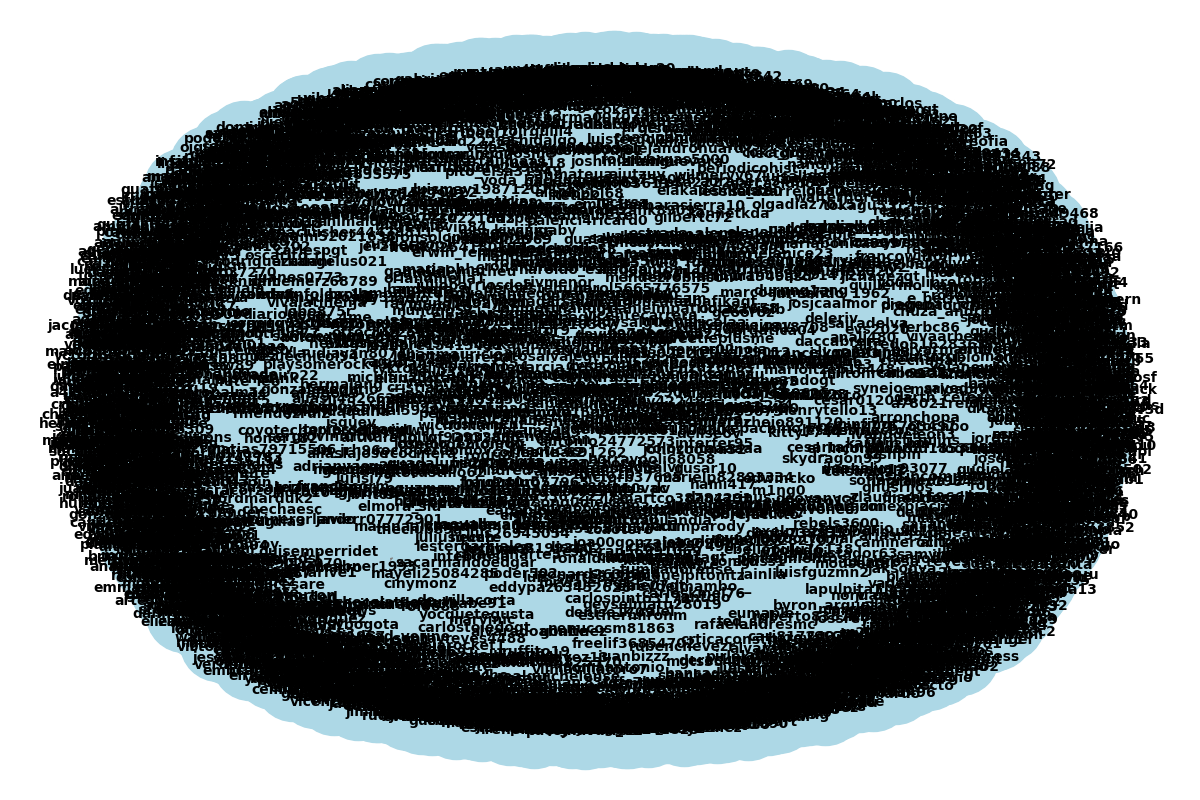

In [208]:

png_file = "MencionesV1.png"
dot_file = "MencionesV1.dot"

if not (os.path.exists(png_file) and os.path.exists(dot_file)):
    interactions = []
    for index, row in df_tweets_cleaned.iterrows():
        author = row['user']  
        author = author['username']
        mentioned_users = row['mentionedUsers'] 
        
        if isinstance(mentioned_users, list):
            for user in mentioned_users:
                mention = user.get('username', '').lower()
                if mention: 
                    interactions.append((author, mention))

    df_interactions = pd.DataFrame(interactions, columns=['source', 'target'])
    G = nx.from_pandas_edgelist(df_interactions, source='source', target='target', create_using=nx.DiGraph())
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=50) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold', arrows=True)
    plt.title("Grafo de menciones a usuarios en Twitter")
    plt.savefig("MencionesV1.png")
    write_dot(G, 'MencionesV1.dot')
else:
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")


En la segunda versión se ocultan los nombres y se decide reducir el tamaño de los nodos. 

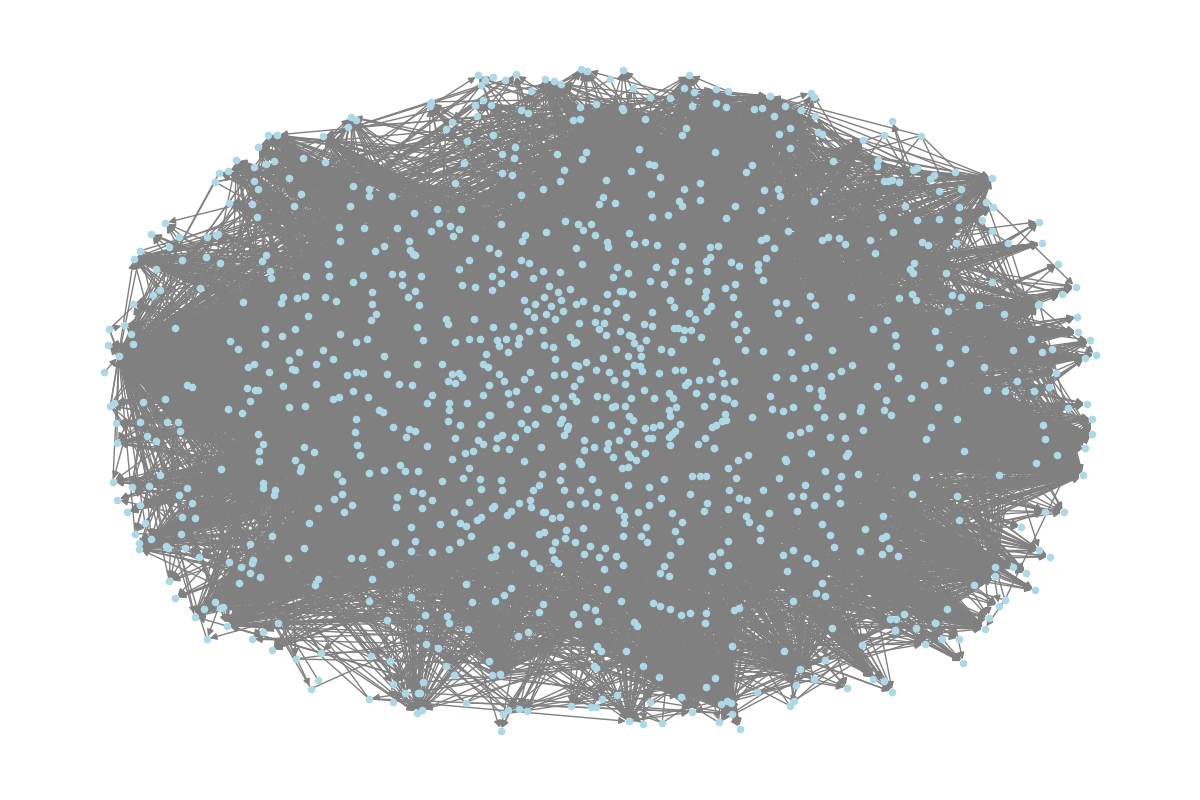

In [209]:
png_file = "MencionesV2.png"
dot_file = "MencionesV2.dot"

if not (os.path.exists(png_file) and os.path.exists(dot_file)):
    interactions = []
    for index, row in df_tweets_cleaned.iterrows():
        author = row['user']  
        author = author['username']
        mentioned_users = row['mentionedUsers'] 
        
        if isinstance(mentioned_users, list):
            for user in mentioned_users:
                mention = user.get('username', '').lower()
                if mention: 
                    interactions.append((author, mention))

    df_interactions = pd.DataFrame(interactions, columns=['source', 'target'])
    G = nx.from_pandas_edgelist(df_interactions, source='source', target='target', create_using=nx.DiGraph())
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=50) 
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=20, font_size=12, font_weight='bold', arrows=True)
    plt.title("Grafo de menciones a usuarios en Twitter")
    plt.savefig(png_file)
    write_dot(G, dot_file)
else:
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")

Luego, para visualizar relaciones más relevantes se establece que solo se muestren los nodos con grado mayor a 5. 

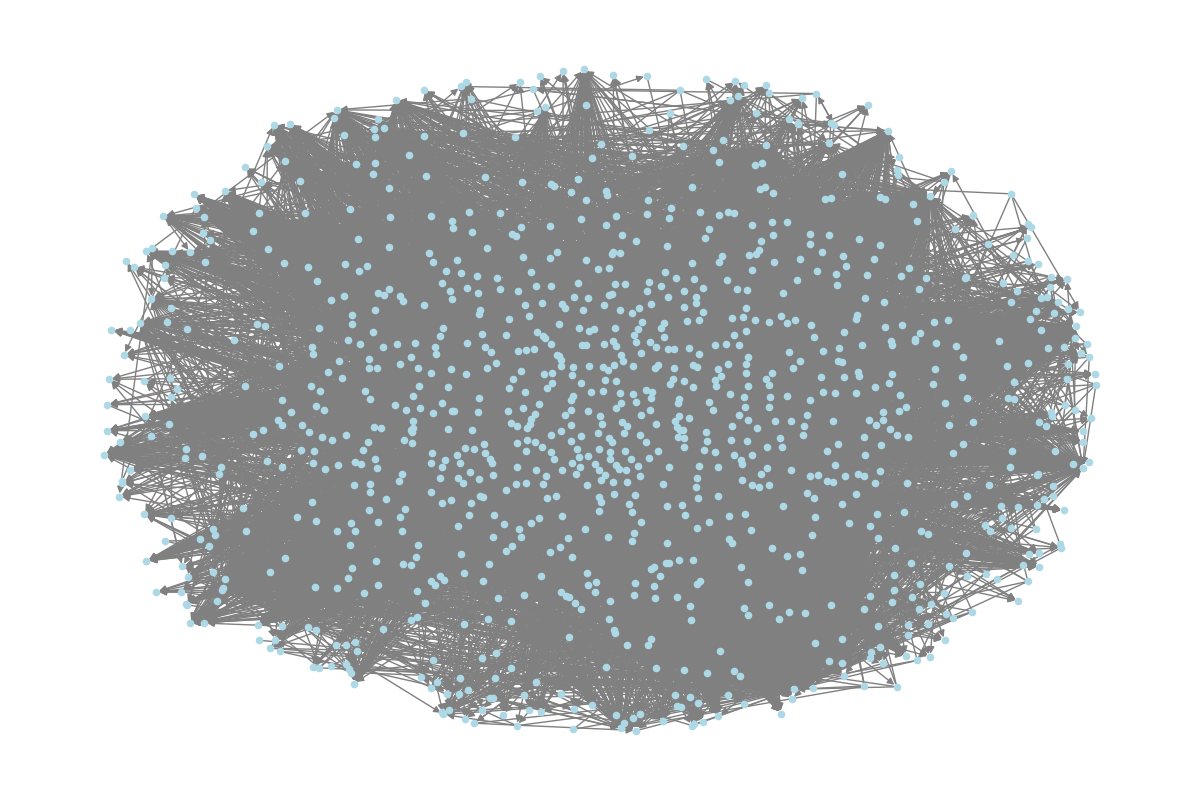

In [210]:

def load_graph_from_dot(dot_file):
    G = read_dot(dot_file)
    return G

def create_subgraph_by_degree(G, min_degree=1):
    nodes_to_keep = [node for node, degree in dict(G.degree()).items() if degree >= min_degree]
    subgraph = G.subgraph(nodes_to_keep).copy()
    return subgraph

if not os.path.exists('MencionesV3.png'):
    G = load_graph_from_dot('MencionesV2.dot')
    min_degree = 5 
    G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, k=0.5, iterations=50)
    nx.draw(G_sub, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=20, font_size=10, font_weight='bold', arrows=True)
    plt.title(f"Grafo de menciones (Nodos con grado >= {min_degree})")
    plt.savefig("MencionesV3.png")
else:
    if os.path.exists('MencionesV3.png'):
        img = Image(filename='MencionesV3.png')
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {'MencionesV3.png'}")    


Debido a que no se logran observar patrones debido a la cantidad de relaciones, se amuentra el grado para visualizar solo los nodos que sean mayor o igual que 10. 

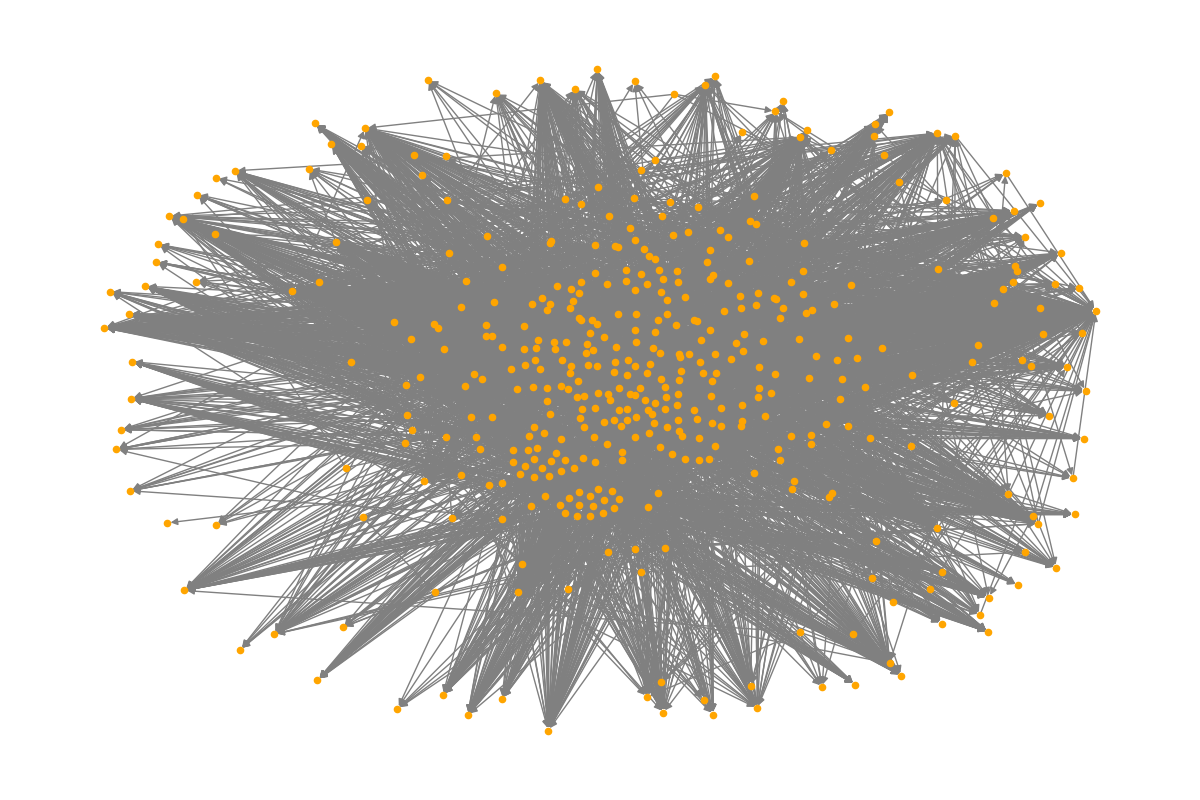

In [211]:
png_file = "MencionesV4.png"
if not os.path.exists(png_file):
    G = load_graph_from_dot('MencionesV2.dot')
    min_degree = 10
    G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, k=0.5, iterations=50)
    nx.draw(G_sub, pos, with_labels=False, node_color='orange', edge_color='gray', node_size=20, font_size=10, font_weight='bold', arrows=True)
    plt.title(f"Grafo de menciones (Nodos con grado >= {min_degree})")
    plt.savefig("MencionesV4.png")
else:
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")    

Finalmente, dado que aun no se perciben relaciones evidentes, se oculta la dirección de las aristas y el grado mínimo de visualización se eleva a 20. 

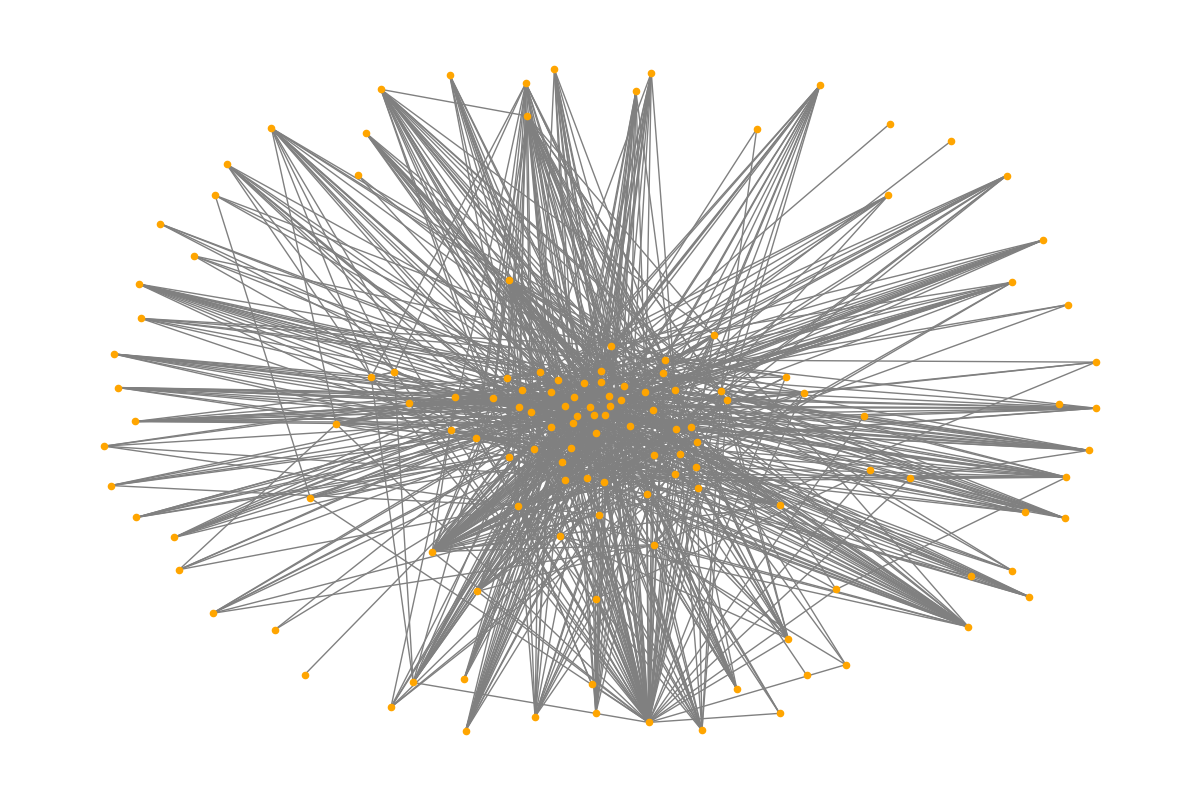

In [212]:
png_file = "MencionesV5.png"
if not os.path.exists(png_file):
    G = load_graph_from_dot('MencionesV2.dot')
    min_degree = 20
    G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, k=0.5, iterations=50)
    nx.draw(G_sub, pos, with_labels=False, node_color='orange', edge_color='gray', node_size=20, font_size=10, font_weight='bold', arrows=False)
    plt.title(f"Grafo de menciones (Nodos con grado >= {min_degree})")
    plt.savefig(png_file)
else:
    if os.path.exists(png_file):
        img = Image(filename=png_file)
        display(img)
    else:
        print(f"No se encontró el archivo PNG: {png_file}")    

Se desarrolla una matriz de adyacencia para observar las relaciones entre los nodos y tener un formato mejor sobre el cual trabajar. 

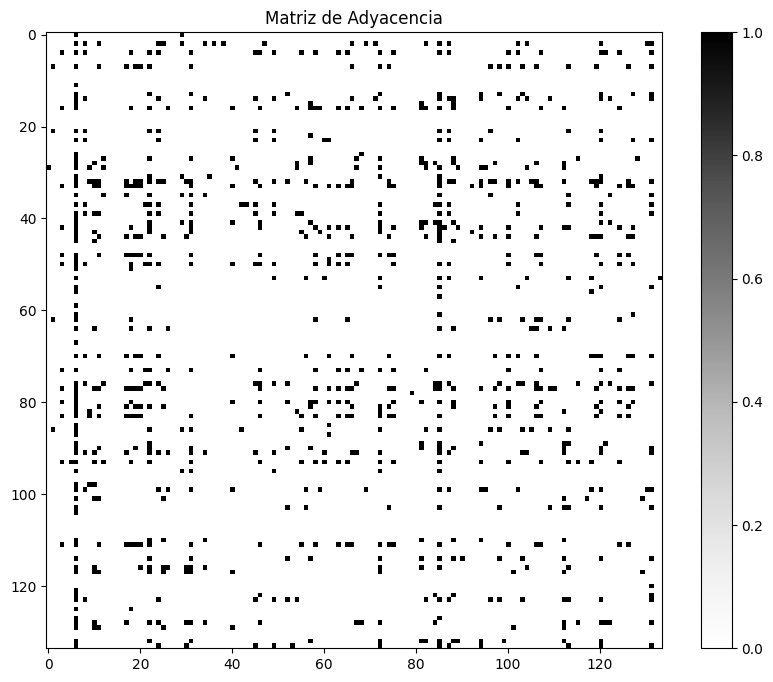

In [213]:
G = load_graph_from_dot('MencionesV2.dot')
min_degree = 20
G_sub = create_subgraph_by_degree(G, min_degree=min_degree)
adj_matrix = nx.to_pandas_adjacency(G_sub)
plt.figure(figsize=(10, 8))
plt.imshow(adj_matrix, cmap='Greys', interpolation='none')
plt.title("Matriz de Adyacencia")
plt.colorbar()
plt.show()

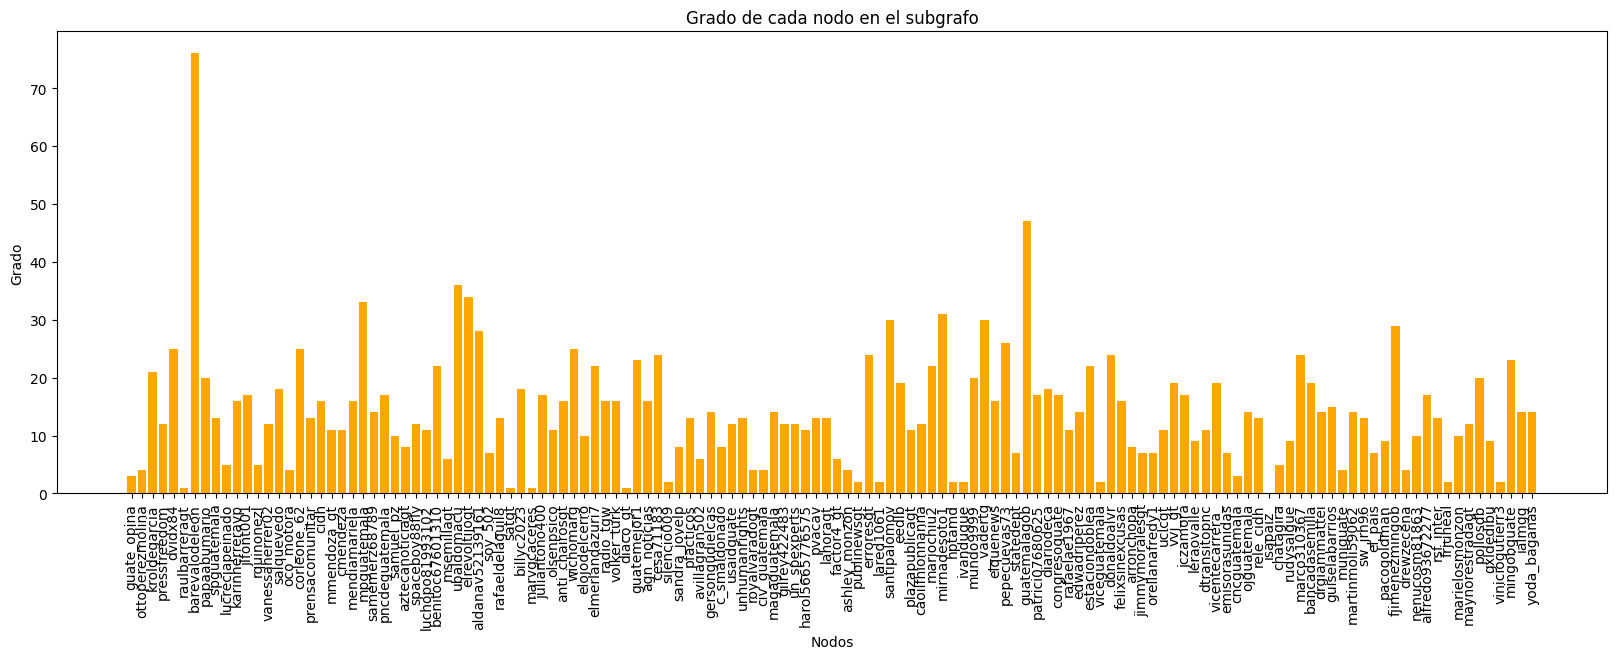

In [214]:
degrees = dict(G_sub.degree())
nodes = list(degrees.keys())
degree_values = list(degrees.values())
plt.figure(figsize=(20, 6))
plt.bar(nodes, degree_values, color='orange')
plt.xlabel('Nodos')
plt.ylabel('Grado')
plt.title('Grado de cada nodo en el subgrafo')
plt.xticks(rotation=90) 
plt.show()

Para una visualización más clara, se puede utiliza un grafico de barras horizontal. De este se logra destacar que los usuarios más mencionados son del presidente, el ministerio de gobernación, fjimenezmingob y ubaldomacu. 

In [215]:
density = nx.density(G_sub)
print(f'Densidad de la red: {density:.4f}')

if nx.is_strongly_connected(G_sub):
    lengths = dict(nx.all_pairs_shortest_path_length(G_sub))
    max_length = max(max(lengths[node].values()) for node in lengths)
    print(f'Diámetro de la red: {max_length}')
    average_clustering = nx.average_clustering(G_sub, weight=None)
    print(f'Coeficiente de agrupamiento promedio: {average_clustering:.4f}')
    node_clustering = nx.clustering(G_sub, weight=None)
    print('Coeficiente de agrupamiento de cada nodo:')
    for node, clustering in node_clustering.items():
        print(f'Nodo {node}: {clustering:.4f}')
else:
    print('La red no está fuertemente conectada, el diámetro y el coeficiente de agrupamiento no están definidos.')

Densidad de la red: 0.0528
La red no está fuertemente conectada, el diámetro y el coeficiente de agrupamiento no están definidos.


### 👩🏽‍👧🏼‍👦🏿 Identificación de análisis de comunidades

Para el análisis de comunidades en la red se utilizó el algoritmo de Louvain, el cual va optimizando la modularidad, la medida que evalúa la densidad de conexiones dentro de las comunidades en comparación con fuera de ellas. 

In [216]:
# Convertir a grafo no dirigido para Louvain
G_undirected = G_sub.to_undirected()

# Aplicar el algoritmo de Louvain
partition = community_louvain.best_partition(G_undirected)

# Agregar la comunidad como un atributo del nodo
nx.set_node_attributes(G_undirected, partition, 'community')

# Imprimir las comunidades detectadas
num_communities = len(set(partition.values()))
print(f'Número de comunidades detectadas: {num_communities}')


Número de comunidades detectadas: 6


Al hacerlo para nuestro grado se puede ver que se obtuvieron 6 comunidades, por lo que a continuación se obtiene el tamaño de estas para así tener las 3 de mayor tamaño y graficarlas de distinto color para ver como se visualizan dentro del grafo

C:\Users\daher\AppData\Local\Temp\ipykernel_24688\987838142.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_communities)


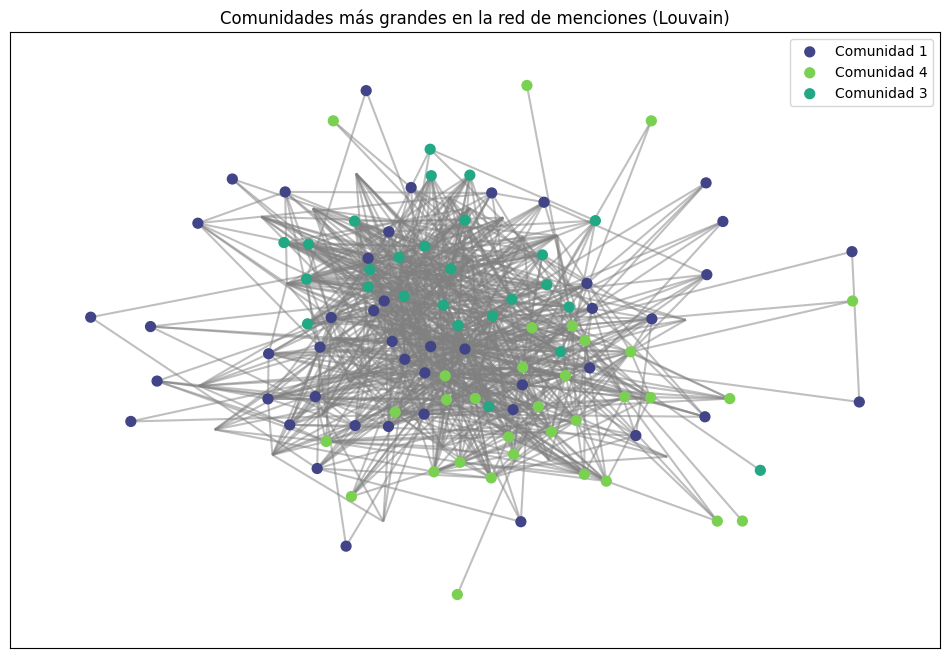

In [217]:
# Obtener el tamaño de cada comunidad
community_sizes = {community: list(partition.values()).count(community) for community in set(partition.values())}
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:3]

# Asignar un color a cada comunidad
colors = cm.get_cmap('viridis', num_communities)

plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G_undirected, k=0.7, iterations=50)

for community in largest_communities:
    nodes = [node for node in partition if partition[node] == community]
    nx.draw_networkx_nodes(G_undirected, pos, nodes, node_size=50, 
                           node_color=[colors(community)] * len(nodes), label=f'Comunidad {community}')
    
nx.draw_networkx_edges(G_undirected, pos, edge_color='gray', width=1.5, alpha=0.5)

# Eliminar etiquetas de los nodos si no son necesarias
#nx.draw_networkx_labels(G_undirected, pos)
plt.title("Comunidades más grandes en la red de menciones (Louvain)")
plt.legend()
plt.show()


Luego obtuvimos distintas características de las comunidades como lo es cantidad de nodos, interacciones, es decir cantidad de aristas, su densidad, y los usuarios de los nodos más influyentes en la comunidad. Con ello podemos ver que la comunidad con menos aristas y nodos tiene mayor densidad, lo cual nos dice que las conexiones las tiene mucho más concentradas.

In [218]:
# Caracterización de las comunidades
for community in largest_communities:
    nodes = [node for node in partition if partition[node] == community]
    subgraph = G_undirected.subgraph(nodes)
    
    # Tamaño de la comunidad
    size = len(nodes)
    density = nx.density(subgraph)
    
    # Número de interacciones (aristas) dentro de la comunidad
    num_edges = subgraph.number_of_edges()
    
    # Nodos más influyentes (grado más alto)
    top_nodes = sorted(subgraph.degree, key=lambda x: x[1], reverse=True)[:3]
    
    print(f"Comunidad {community}:")
    print(f"Tamaño: {size} nodos")
    print(f"Interacciones: {num_edges} aristas")
    print(f"Densidad: {density:.4f}")
    print(f"Nodos más influyentes: {top_nodes}")
    print("\n")


Comunidad 1:
Tamaño: 45 nodos
Interacciones: 167 aristas
Densidad: 0.1687
Nodos más influyentes: [('barevalodeleon', 30), ('__vadertg', 16), ('mpguatemala', 16)]


Comunidad 4:
Tamaño: 32 nodos
Interacciones: 127 aristas
Densidad: 0.2560
Nodos más influyentes: [('guatemalagob', 15), ('kroldegarcia', 14), ('fjimenezmingob', 13)]


Comunidad 3:
Tamaño: 26 nodos
Interacciones: 121 aristas
Densidad: 0.3723
Nodos más influyentes: [('aldanav52139161', 13), ('mundo9999', 13), ('cesa71183', 13)]




### 🟢 Análisis de influencers y nodos clave

Luego se realizó el análisis de influencers y nodos claves, en el cual obtuvimos varias métricas de centralidad de los nodos para así obtener los 5 usuarios más influyentes dentro de la red.

La primera métrica realizada fue la centralidad de grado, es decir usuarios con más conexiones directas es decir más menciones o retweets.

In [219]:
# Centralidad de grado
degree_centrality = nx.degree_centrality(G_sub)

# Mostrar los 5 usuarios con mayor centralidad de grado
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Usuarios con mayor centralidad de grado:\n")
for user, centrality in top_degree:
    print(f"Usuario: {user}, Centralidad de grado: {centrality:.4f}")


Usuarios con mayor centralidad de grado:

Usuario: barevalodeleon, Centralidad de grado: 0.5714
Usuario: guatemalagob, Centralidad de grado: 0.3534
Usuario: ubaldomacu, Centralidad de grado: 0.2707
Usuario: elrevoltijogt, Centralidad de grado: 0.2556
Usuario: mpguatemala, Centralidad de grado: 0.2481


Luego usamos centralidad de intermediación para obtener cuáles usuarios actuan como puentes en la red conectando comunidades.

In [220]:
# Centralidad de intermediación
betweenness_centrality = nx.betweenness_centrality(G_sub, normalized=True)

# Mostrar los 5 usuarios con mayor centralidad de intermediación
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nUsuarios con mayor centralidad de intermediación:\n")
for user, centrality in (top_betweenness):
    print(f"Usuario: {user}, Centralidad de intermediación: {centrality:.4f}")



Usuarios con mayor centralidad de intermediación:

Usuario: ubaldomacu, Centralidad de intermediación: 0.0421
Usuario: benitoc67601310, Centralidad de intermediación: 0.0389
Usuario: __vadertg, Centralidad de intermediación: 0.0220
Usuario: anti_chairosgt, Centralidad de intermediación: 0.0112
Usuario: rafaeldelaguil8, Centralidad de intermediación: 0.0090


Y por último se hizo la centralidad de cercanía para obtener los usuarios que pueden llegar a todos los nodos con la menor cantidad de saltos.

In [221]:
# Centralidad de cercanía
closeness_centrality = nx.closeness_centrality(G_sub)

# Mostrar los 5 usuarios con mayor centralidad de cercanía
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Usuarios con mayor centralidad de cercanía:\n")
for user, centrality in top_closeness:
    print(f"Usuario: {user}, Centralidad de cercanía: {centrality:.4f}")


Usuarios con mayor centralidad de cercanía:

Usuario: barevalodeleon, Centralidad de cercanía: 0.5647
Usuario: guatemalagob, Centralidad de cercanía: 0.3482
Usuario: santipalomov, Centralidad de cercanía: 0.2548
Usuario: mpguatemala, Centralidad de cercanía: 0.2496
Usuario: fjimenezmingob, Centralidad de cercanía: 0.2473


Luego se realizaron 3 gráficos, uno por cada métrica donde se aprecia las centralidades calculadas en las redes aumentanto el tamaño y color de los nodos cuando tienen una mayor centralidad. Por ello podemos ver que tenemos mayores usuarios relacionados con métricas de centralidad de grado y cercanía que por centralidad de intermediación, de los cuales se obtuvieron cantidades más pequeñas a comparación de las otras dos métricas.

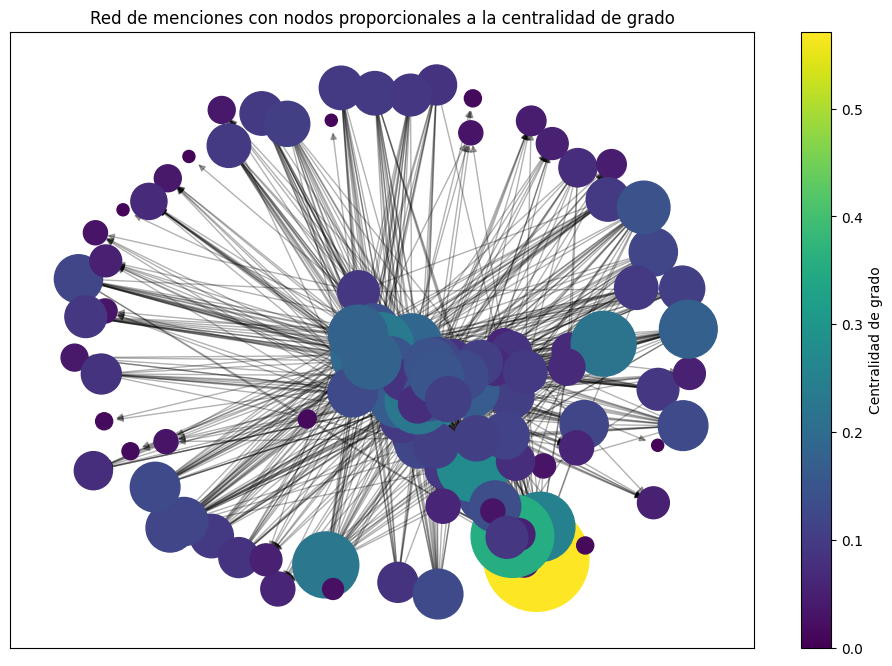

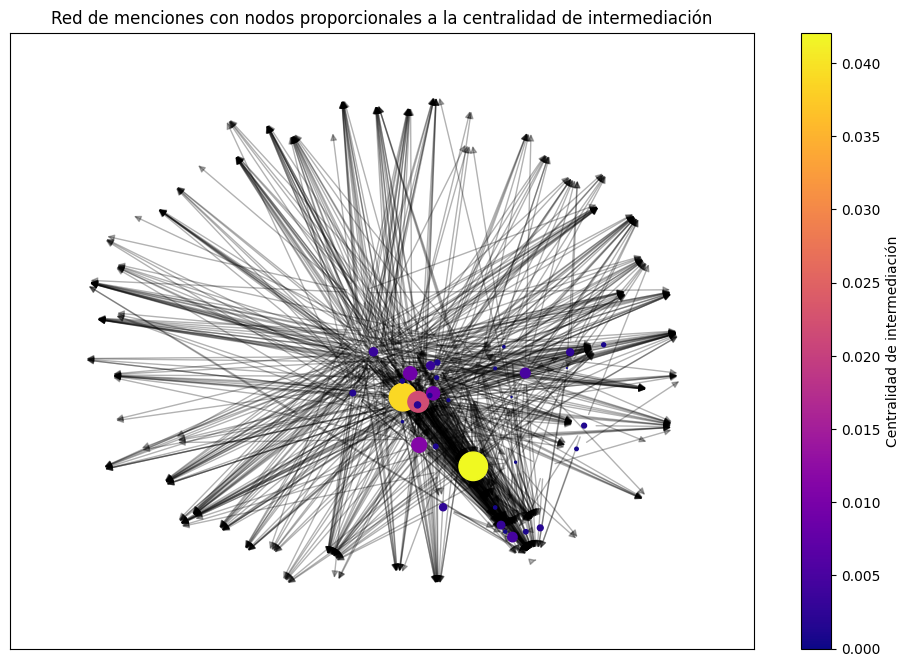

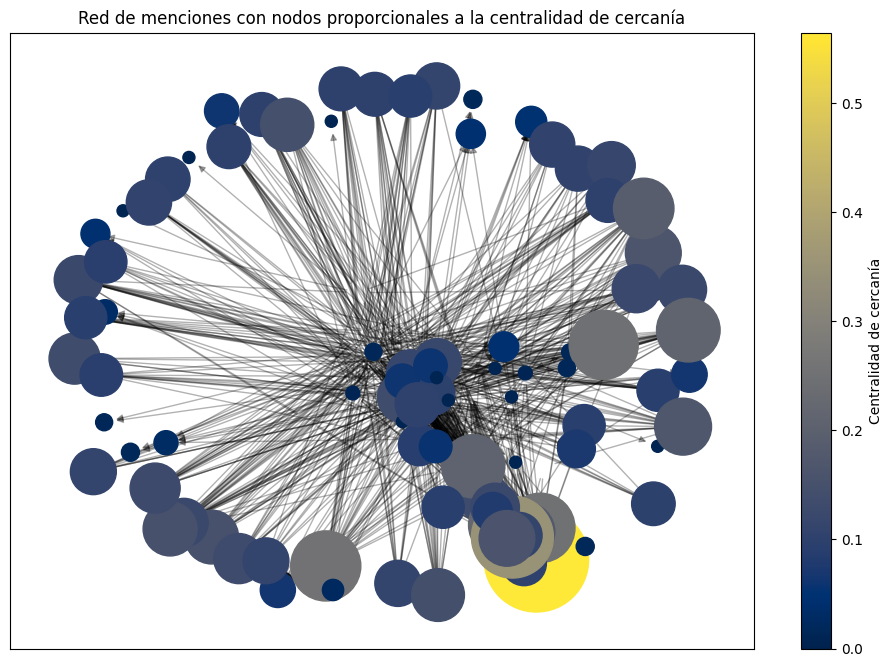

In [222]:
pos = nx.spring_layout(G_sub)

# Visualización de centralidad de grado
plt.figure(figsize=(12, 8))
node_size = [v * 10000 for v in degree_centrality.values()]
node_color = np.array(list(degree_centrality.values()))
nodes = nx.draw_networkx_nodes(G_sub, pos, node_size=node_size, node_color=node_color, cmap='viridis')
nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
plt.title("Red de menciones con nodos proporcionales a la centralidad de grado")
plt.colorbar(nodes, label="Centralidad de grado")  # Asignar la colorbar al objeto 'nodes'
plt.show()

# Visualización de centralidad de intermediación
plt.figure(figsize=(12, 8))
node_size_betweenness = [v * 10000 for v in betweenness_centrality.values()]
node_color_betweenness = np.array(list(betweenness_centrality.values()))
nodes_betweenness = nx.draw_networkx_nodes(G_sub, pos, node_size=node_size_betweenness, node_color=node_color_betweenness, cmap='plasma')
nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
plt.title("Red de menciones con nodos proporcionales a la centralidad de intermediación")
plt.colorbar(nodes_betweenness, label="Centralidad de intermediación")
plt.show()

# Visualización de centralidad de cercanía
plt.figure(figsize=(12, 8))
node_size_closeness = [v * 10000 for v in closeness_centrality.values()]
node_color_closeness = np.array(list(closeness_centrality.values()))
nodes_closeness = nx.draw_networkx_nodes(G_sub, pos, node_size=node_size_closeness, node_color=node_color_closeness, cmap='cividis')
nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
plt.title("Red de menciones con nodos proporcionales a la centralidad de cercanía")
plt.colorbar(nodes_closeness, label="Centralidad de cercanía")
plt.show()

### 🧑🏽‍💼 Detección y análisis de grupos aislados

En esta sección se identificaron componentes para el análisis de grupos aislados, donde se tomaron componenetes débilmente conexos y fuertemente conexos para obtener subredes o posibles grupos aislados, donde se obtuvieron que 2 subredes son las que están debilmente conectadas versus que 123 están fuertemente conectadas.

In [223]:
# Identificar componentes débilmente conexos (considera la estructura como un grafo no dirigido)
weakly_connected_components = list(nx.weakly_connected_components(G_sub))
print(f"Número de subredes débilmente conectadas: {len(weakly_connected_components)}")

# Identificar componentes fuertemente conexos
strongly_connected_components = list(nx.strongly_connected_components(G_sub))
print(f"Número de subredes fuertemente conectadas: {len(strongly_connected_components)}")


Número de subredes débilmente conectadas: 2
Número de subredes fuertemente conectadas: 123


Por lo que se procedió a la búsqueda de estas subredes aisladas, donde se ve una más grande que otra pero una contiene 133 nodos y se describen sus respectivos usuarios, y la otra solo tiene un nodo, estando totalmente aislado el nodo.

In [224]:
# Subredes aisladas (componentes pequeños)
small_components = [comp for comp in weakly_connected_components if len(comp) < 200]  
print(f"Subredes pequeñas (menos de 200 nodos): {len(small_components)}")

# Opcional: Mostrar nodos en alguna subred pequeña
for i, comp in enumerate(small_components):
    print(f"Subred {i+1}, Longitud: {len(comp)}: {comp}")

Subredes pequeñas (menos de 200 nodos): 2
Subred 1, Longitud: 133: {'guate_opina', 'ottoperezmolina', 'kroldegarcia', 'pressfreedom', 'dvidx84', 'raulbarreragt', 'barevalodeleon', 'papaabumario', '_spguatemala', 'lucreciapeinado', 'karinherreravp', 'jlfont001', 'rquinonezl', 'vanessaherrer02', 'salquevedo', 'oco_motora', 'corleone_62', 'prensacomunitar', 'cidh', 'mmendoza_gt', 'cmendeza', 'mendiamariela', 'mpguatemala', 'samemerz68789', 'pncdeguatemala', 'samuel_pz', 'aztecanoticiagt', 'spaceboy88fly', 'luchopo81993102', 'benitoc67601310', 'ubaldomacu', 'msemillagt', 'elrevoltijogt', 'aldanav52139161', 'soy_502', 'rafaeldelaguil8', 'satgt', 'billyc2023', 'marvgcaceres', 'juliantono400', 'olsenpsico', 'anti_chairosgt', 'wichomarg', 'elojodelcerro', 'elmerlandazuri7', 'radio_tgw', 'diaco_gt', 'volker_turk', 'guatemejor1', 'agn_noticias', 'cesa71183', 'silencio009', 'pfacticos', 'sandra_jovelp', 'avillagran502', 'gersongudielcas', 'c_smaldonado', 'usaidguate', 'unhumanrights', 'royalvarad

De estas dos redes se puede ver que se calculó las interacciones que tienen entre nodos, teniendo la más grande con 941 interacciones y la otra con 0, haciendo que su densidad sea bastante pequeña y hasta nula, siento 0.0536 y 0 respectivamente.

In [225]:
# Analizar una de las subredes aisladas (por ejemplo, la primera subred pequeña)
isolated_subgraph_nodes = list(small_components[0])
isolated_subgraph = G_sub.subgraph(isolated_subgraph_nodes)

isolated_subgraph_nodes2 = list(small_components[1])
isolated_subgraph2 = G_sub.subgraph(isolated_subgraph_nodes2)

# Mostrar algunas estadísticas de la subred aislada
print(f"Subred aislada con {len(isolated_subgraph)} nodos y {isolated_subgraph.size()} interacciones.")

# Calcular la densidad de la subred
density_isolated = nx.density(isolated_subgraph)
print(f'Densidad de la subred aislada: {density_isolated:.4f}')

# Mostrar la centralidad de grado en la subred aislada
degree_centrality_isolated = nx.degree_centrality(isolated_subgraph)
print(f"Centralidad de grado de la subred aislada: {degree_centrality_isolated}")

# Mostrar algunas estadísticas de la subred aislada
print(f"\nSubred aislada con {len(isolated_subgraph2)} nodos y {isolated_subgraph2.size()} interacciones.")

# Calcular la densidad de la subred
density_isolated2 = nx.density(isolated_subgraph2)
print(f'Densidad de la subred aislada: {density_isolated2:.4f}')

# Mostrar la centralidad de grado en la subred aislada
degree_centrality_isolated2 = nx.degree_centrality(isolated_subgraph2)
print(f"Centralidad de grado de la subred aislada: {degree_centrality_isolated2}")


Subred aislada con 133 nodos y 941 interacciones.
Densidad de la subred aislada: 0.0536
Centralidad de grado de la subred aislada: {'guate_opina': 0.022727272727272728, 'ottoperezmolina': 0.030303030303030304, 'kroldegarcia': 0.1590909090909091, 'pressfreedom': 0.09090909090909091, 'dvidx84': 0.1893939393939394, 'raulbarreragt': 0.007575757575757576, 'barevalodeleon': 0.5757575757575758, 'papaabumario': 0.15151515151515152, '_spguatemala': 0.09848484848484848, 'lucreciapeinado': 0.03787878787878788, 'karinherreravp': 0.12121212121212122, 'jlfont001': 0.12878787878787878, 'rquinonezl': 0.03787878787878788, 'vanessaherrer02': 0.09090909090909091, 'salquevedo': 0.13636363636363635, 'oco_motora': 0.030303030303030304, 'corleone_62': 0.1893939393939394, 'prensacomunitar': 0.09848484848484848, 'cidh': 0.12121212121212122, 'mmendoza_gt': 0.08333333333333334, 'cmendeza': 0.08333333333333334, 'mendiamariela': 0.12121212121212122, 'mpguatemala': 0.25, 'samemerz68789': 0.10606060606060606, 'pncde

Luego se muestra un pequeño gráfico para ver el ambos grupos aislados viendo que el de 133 nodos a pesar de ser pequeño en comparación al resto del grafo tiene bastantes interacciones, versus la otra que solo contiene un usuario la cual no está conectado ni interactuando con ningún otro usuario.

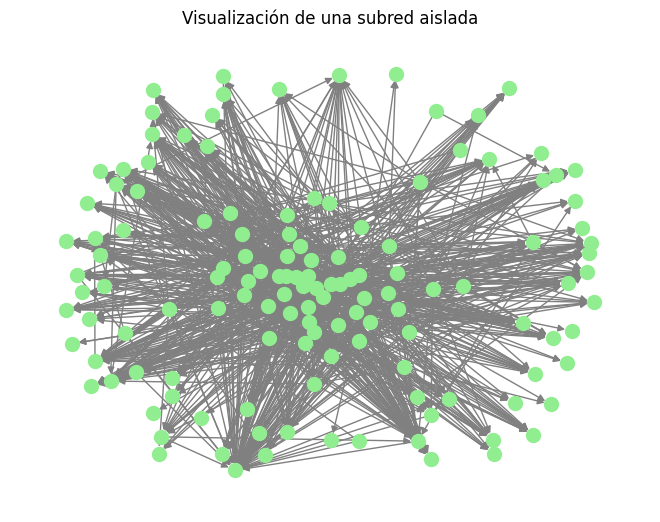

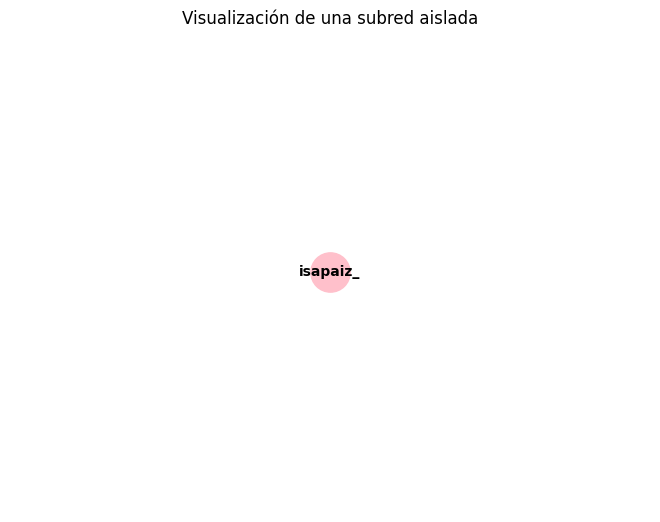

In [226]:
# Visualización de una subred aislada
pos = nx.spring_layout(isolated_subgraph, k=0.5, iterations=20)
nx.draw(isolated_subgraph, pos, with_labels=False, node_color='lightgreen', edge_color='gray', node_size=100)
plt.title("Visualización de una subred aislada")
plt.show()


# Visualización de una subred aislada
pos = nx.spring_layout(isolated_subgraph2, k=0.5, iterations=20)
nx.draw(isolated_subgraph2, pos, with_labels=True, node_color='pink', edge_color='gray', node_size=800, font_size=10, font_weight='bold')
plt.title("Visualización de una subred aislada")
plt.show()


### 💓 Análisis de contenido y sentimiento

Por último realizamos un análisis de sentimiento analizando las palabras de los tweets en nuestra red donde se puede ver que la mayoría de palabras son neutrales, luego le siguen algunas positivas y por último las negativas que son minoría pero más emparejadas con las positivas.

In [232]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def analyze_tweet_sentiment(tweet):
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    words = tweet.split()
    
    for word in words:
        sentiment = sia.polarity_scores(word)  # Obtener el puntaje de sentimiento de cada palabra
        
        if sentiment['compound'] >= 0.05:  # Si es positivo
            positive_count += 1
        elif sentiment['compound'] <= -0.05:  # Si es negativo
            negative_count += 1
        else:  # Si es neutral
            neutral_count += 1
    
    total_words = len(words)
    
    if total_words == 0:
        return "Neutral", positive_count, negative_count, neutral_count
    
    positive_percentage = (positive_count / total_words) * 100
    negative_percentage = (negative_count / total_words) * 100
    neutral_percentage = (neutral_count / total_words) * 100
    
    if positive_percentage > negative_percentage:
        sentiment = f"Positivo ({positive_percentage:.2f}%)"
    elif negative_percentage > positive_percentage:
        sentiment = f"Negativo ({negative_percentage:.2f}%)"
    else:
        sentiment = f"Neutral ({neutral_percentage:.2f}%)"
    
    return sentiment, positive_count, negative_count, neutral_count

sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}

tweet_list = []
for tweet in df_tweets_cleaned['rawContent']:
    tweet_text = str(tweet)  
    
    sentiment_score = sia.polarity_scores(tweet_text)
    if sentiment_score['compound'] >= 0.05:
        sentiments['positive'] += 1
    elif sentiment_score['compound'] <= -0.05:
        sentiments['negative'] += 1
    else:
        sentiments['neutral'] += 1
    
    word_sentiment, pos_count, neg_count, neu_count = analyze_tweet_sentiment(tweet_text)
    
    tweet_list.append({
        'tweet': tweet_text,
        'tweet_sentiment': word_sentiment,
        'positive_words': pos_count,
        'negative_words': neg_count,
        'neutral_words': neu_count
    })

for i, tweet_data in enumerate(tweet_list[:100]):
    print(f" \n🐦 Tweet {i+1}: {tweet_data['tweet']}")
    print(f"Sentimiento: {tweet_data['tweet_sentiment']}")
    print(f"Palabras positivas: {tweet_data['positive_words']}")
    print(f"Palabras negativas: {tweet_data['negative_words']}")
    print(f"Palabras neutrales: {tweet_data['neutral_words']}")
    print()

print(f"Sentimientos positivos: {sentiments['positive']}")
print(f"Sentimientos negativos: {sentiments['negative']}")
print(f"Sentimientos neutrales: {sentiments['neutral']}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


 
🐦 Tweet 1: confirmado compañeres impuesto  solo cuenta pagado apoyo  través    huye esconde verdadero pueblo guatemalteco
Sentimiento: Neutral (100.00%)
Palabras positivas: 0
Palabras negativas: 0
Palabras neutrales: 13

 
🐦 Tweet 2:  medios  informaron ayer acerca visita presidente   sacado toda prisa  manifestantes pedían ser escuchados mandatario decidió huir manera 
Sentimiento: Neutral (100.00%)
Palabras positivas: 0
Palabras negativas: 0
Palabras neutrales: 17

 
🐦 Tweet 3:   usaste pegasus espiar detractores obra narcisista conciencia buena pinta corazon negro podrido dentro alma
Sentimiento: Neutral (100.00%)
Palabras positivas: 0
Palabras negativas: 0
Palabras neutrales: 14

 
🐦 Tweet 4:   entienden bien cuadrando productivareunión
Sentimiento: Neutral (100.00%)
Palabras positivas: 0
Palabras negativas: 0
Palabras neutrales: 4

 
🐦 Tweet 5: presidente  vicepresidenta  participan sesión solemne conmemoración 203 aniversario independencia república guatemala  
Sentimiento: Neu

Luego se realizo un análisis de tópicos con LDA, el cual consiste en la múltiplicación de la probabilidad de la palabra de aparecer en ese tema por la respectiva palabra, donde podemos ver que tenemos 4 temas y cada uno con sus palabras relacionadas al tema con su respectiva probabilidad de aparecer dentro de este.

In [229]:
sia = SentimentIntensityAnalyzer()

nltk.download('punkt_tab')


# Análisis de Tópicos con LDA
# Crear el diccionario y el corpus
tokenized_texts = df_tweets_cleaned['rawContent'].apply(word_tokenize)
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Entrenar el modelo LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# Mostrar los temas
topics = lda_model.print_topics(num_words=10)
print("\nTemas identificados:")
for idx, topic in topics:
    print(f"Tema {idx}: {topic}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Temas identificados:
Tema 0: 0.010*"gobierno" + 0.008*"presidente" + 0.007*"corruptos" + 0.006*"mejor" + 0.006*"así" + 0.005*"si" + 0.004*"hacer" + 0.004*"hace" + 0.004*"bien" + 0.004*"puede"
Tema 1: 0.008*"si" + 0.006*"ahora" + 0.006*"guatemala" + 0.006*"corrupción" + 0.005*"presidente" + 0.005*"años" + 0.005*"debe" + 0.005*"sos" + 0.004*"ser" + 0.004*"país"
Tema 2: 0.006*"si" + 0.006*"salud" + 0.006*"guatemala" + 0.005*"gobierno" + 0.005*"arévalo" + 0.005*"solo" + 0.005*"pueblo" + 0.005*"presidente" + 0.004*"corruptos" + 0.004*"corrupción"
Tema 3: 0.016*"si" + 0.012*"q" + 0.009*"gobierno" + 0.006*"vos" + 0.005*"solo" + 0.005*"mierda" + 0.005*"mejor" + 0.005*"así" + 0.004*"va" + 0.004*"usted"
Tema 4: 0.012*"solo" + 0.007*"jajaja" + 0.006*"presidente" + 0.005*"semilla" + 0.005*"hacer" + 0.005*"si" + 0.004*"diputados" + 0.003*"q" + 0.003*"hambre" + 0.003*"fraudulento"


Con la información recopilada, se puede determinar que los influencers y comunidades detectadas durante el análisis de los tweets, muestran un papel significativo en la forma de modelar la opinión pública. Usuarios como barevalodeleon y guatemalagob son actores clave debido a su alta centralidad de grado y centralidad de cercanía. Esto nos indica que tienen una amplica conexión con otros nodos y por lo tanto, cuentan con gran influencia en la transmisión de información y la formación de opiniones. 

Estos nodos no solo son usuarios centrales, si no que forman parte de una estructura, que en el caso del presidente, podrían estar configurados para modelar la percepción positiva o negativa de su gobierno. 

Definitivamente existe polarización de opiniones dado la diversidad de hashtags y palabras mencionadas, destacando "#yonotengopresidente". El uso de palabras como netcenter o semillo podria revelar la existencia de grupos organizados no significativamente grandes pero estructurados con fines específicos para modelar la narrativa en torno al presidente y otros temas de interés nacional. Cabe destacar que no se asegura que estén organizados necesariamente.

Los sentimientos predominantes en los tweets son mayoritariamente neutros (4223), con una cantidad considerable de sentimientos positivos (218) y negativos (104), lo que refleja que no existe una opinión firme por parte de la población. No es posible indicar que existe un descontento o un apoyo directo por parte de la población, lo que sí se puede confirmar es que la diversidad de opiniones presentes indican un sentimiento de incertidumbre presente en todos los ciudadanos. 